In [87]:
import pysam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

def extract_links(bam_file):
    """
    Function to be applied to file after matlock filtering, no unaligned reads should be present.
    Takes a bam file as input and returns the counts for the links present.
    """
    samfile = pysam.AlignmentFile(bam_file, 'rb')
    count = 0
    genomes = {'pB10::rfp_putative':'pB10', 'NC_002947.4':'P.Putida', 'NC_000913.3_gfp':'E.Coli'}
    pB10_pB10 = 0
    pB10_ecoli = 0
    pB10_pputida = 0
    ecoli_ecoli = 0
    pputida_pputida = 0
    multimapped = 0
    pairs = []
    
    for read in samfile.fetch(until_eof=True):
        count += 1
        genome = ''
        name = ''
        cigar = ''
        loc = ''
        seq = read.query_sequence
        length = len(seq)
        if read.is_unmapped:
            name = read.query_name
            genome = 'unaligned'
        if not read.is_unmapped:
            name = read.query_name
            genome = genomes.get(read.reference_name)
            cigar = read.cigarstring
            #match = str(length)+'M'
            loc = read.reference_start
            #if cigar != match:
            #    genome='unaligned'
        pairs.append([name, genome, loc, length, read.get_tags(), read])
        if count % 2 == 0:
            r1_multimapped = check_alt(pairs[0][1], pairs[0][4], pairs[0][3])
            r2_multimapped = check_alt(pairs[1][1], pairs[1][4], pairs[1][3])
            if len(r1_multimapped) > 1 or len(r2_multimapped) >1:
                multimapped += 1
                pairs = []
            else:
                links = pairs[0][1] + pairs[1][1]
                if links == 'pB10pB10':
                    pB10_pB10 += 1
                if links == 'pB10P.Putida':
                    pB10_pputida += 1
                if links == 'P.PutidapB10':
                    pB10_pputida += 1
                if links == 'pB10E.Coli':
                    pB10_ecoli += 1
                if links == 'E.ColipB10':
                    pB10_ecoli += 1
                if links == 'E.ColiE.Coli':
                    ecoli_ecoli += 1 
                if links == 'P.PutidaP.Putida':
                    pputida_pputida += 1
                pairs = []
    return([pB10_pputida, pB10_ecoli, ecoli_ecoli, pB10_pB10, pputida_pputida])

def check_alt(aligned, tags, length):
    """
    This function uses the alignment tags to determine if a read was
    mapped perfectly to multiple references. The output is a list of 
    references to which the read mapped.
    """
    genomes = [aligned]
    for tag in tags:
        if tag[0] == 'XA' or tag[0] == 'SA':
            tag = list(tag)
            others = tag[1].split(';')[:-1]
            fmatch = []
            for alt in others:
                info = alt.split(',')
                if info[-2] == str(length)+'M':
                    fmatch.append(info[0])
            for i in fmatch:
                genomes.append(i)
    return(list(set(genomes)))


os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/05_bwa_alignments/math_model/sorted/')
files = glob.glob('*.bam')
files.sort()

lib = 0
total = len(files)

df = pd.DataFrame(columns = ['Library', 'Depth', 'Trial', 'pB10_pputida'])

for file in files:
    lib += 1
    index = file[0]
    depth = file[2:10]
    trial = file[11]
    
    counts = extract_links(file)
    df = df.append({'Library': index, 'Depth':depth, 'Trial':trial, 'pB10_pputida':counts[0]}, ignore_index=True)
    
    percent = (lib/total)*100            
    print('Library ', index, ' at ', depth, ' sequencing depth and trial ', trial, ' done ::: ', round(percent,2))

Library  B  at  50000000  sequencing depth and trial  1  done :::  0.8
Library  B  at  50000000  sequencing depth and trial  2  done :::  1.6
Library  B  at  50000000  sequencing depth and trial  3  done :::  2.4
Library  B  at  50000000  sequencing depth and trial  4  done :::  3.2
Library  B  at  50000000  sequencing depth and trial  5  done :::  4.0
Library  B  at  60000000  sequencing depth and trial  1  done :::  4.8
Library  B  at  60000000  sequencing depth and trial  2  done :::  5.6
Library  B  at  60000000  sequencing depth and trial  3  done :::  6.4
Library  B  at  60000000  sequencing depth and trial  4  done :::  7.2
Library  B  at  60000000  sequencing depth and trial  5  done :::  8.0
Library  B  at  70000000  sequencing depth and trial  1  done :::  8.8
Library  B  at  70000000  sequencing depth and trial  2  done :::  9.6
Library  B  at  70000000  sequencing depth and trial  3  done :::  10.4
Library  B  at  70000000  sequencing depth and trial  4  done :::  11.2
Libr

Library  F  at  70000000  sequencing depth and trial  5  done :::  92.0
Library  F  at  80000000  sequencing depth and trial  1  done :::  92.8
Library  F  at  80000000  sequencing depth and trial  2  done :::  93.6
Library  F  at  80000000  sequencing depth and trial  3  done :::  94.4
Library  F  at  80000000  sequencing depth and trial  4  done :::  95.2
Library  F  at  80000000  sequencing depth and trial  5  done :::  96.0
Library  F  at  90000000  sequencing depth and trial  1  done :::  96.8
Library  F  at  90000000  sequencing depth and trial  2  done :::  97.6
Library  F  at  90000000  sequencing depth and trial  3  done :::  98.4
Library  F  at  90000000  sequencing depth and trial  4  done :::  99.2
Library  F  at  90000000  sequencing depth and trial  5  done :::  100.0


In [178]:
df.to_csv("~/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_ouput/math_model/read_simulations.csv", index=False)

In [101]:
import os
import pandas as pd
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/')

reads = pd.concat(pd.read_csv('C+_reads.csv', chunksize=1000000, sep=','))
kraken = pd.concat(pd.read_csv('C+_out.kraken2', chunksize=1000000, sep='\t', header=None))
taxon = pd.concat(pd.read_csv('C+_lineage.txt', chunksize=1000000, sep='\t'))
taxon['classified'], taxon['seqid']  = kraken[0], kraken[1]
pothosts = reads.loc[(reads['link']=='unalignedpB10') | (reads['link']=='pB10unaligned')]
pothosts.drop(columns=['Unnamed: 0', 'R1align', 'R1', 'R2align', 'R2'], inplace=True)
complete_df = pothosts.merge(taxon, how='left',on='seqid')
no_unclassified = complete_df[complete_df['classified']=='C']
no_unclassified.drop(columns=['classified','taxid'], inplace=True)

In [135]:
test2 = no_unclassified.drop_duplicates(subset=['link', 'R1loc', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
test2

,seqid,link,R1length,R1loc,R2length,R2loc,kingdom,phylum,class,order,family,genus,species
0,A01335:60:HJVH2DRXY:1:2101:1072:4946,pB10unaligned,159,63095.0,159,2354107.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,NaN,NaN
1,A01335:60:HJVH2DRXY:1:2101:1072:5384,unalignedpB10,159,8230.0,159,8349.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
2,A01335:60:HJVH2DRXY:1:2101:1072:12054,pB10unaligned,159,61297.0,159,3789394.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,NaN,NaN
3,A01335:60:HJVH2DRXY:1:2101:1072:12493,unalignedpB10,159,42492.0,159,42460.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
4,A01335:60:HJVH2DRXY:1:2101:1072:16564,pB10unaligned,159,63687.0,159,2580.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278559,A01335:60:HJVH2DRXY:1:2278:32805:11428,unalignedpB10,159,57699.0,159,57892.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
278560,A01335:60:HJVH2DRXY:1:2278:32823:5760,pB10unaligned,159,17803.0,159,NaN,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,NaN
278561,A01335:60:HJVH2DRXY:1:2278:32832:8876,pB10unaligned,159,40431.0,159,33347.0,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Phyllobacteriaceae,Aquibium,Aquibium oceanicum
278562,A01335:60:HJVH2DRXY:1:2278:32832:12853,unalignedpB10,159,1712140.0,159,48440.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli


In [1]:
global p_unaligned
global p_p
global p_ecoli
p_unaligned = [0]*pb10_len
p_p = [0]*pb10_len
p_ecoli = [0]*pb10_len

NameError: name 'pb10_len' is not defined

In [3]:
import os
import pandas as pd
from operator import add
import numpy as np

def process_data(reads_file, kraken_file, taxon_file):
    """
    Function used for importing files and separating data into each read type. Input is reads_file (alignment file from bwa), 
    kraken_file (kraken output containing the taxids for each unaligned-pputida read), and taxon_file (file containing 
    lineages for each taxid). Output is three dataframes. donor contains only ecoli_pb10 reads, plasmid contains only
    pd10_pb10 reads, and pothosts_classified containes unaligned_pb10 reads. pothosts_classified additionally is merged
    with kraken_file and taxon_file, so it contains taxonomic alignment info for the unaligned portion
    """
    #import the three files
    reads = pd.concat(pd.read_csv(reads_file, chunksize=1000000, sep=','))
    kraken = pd.concat(pd.read_csv(kraken_file, chunksize=1000000, sep='\t', header=None))
    taxon = pd.concat(pd.read_csv(taxon_file, chunksize=1000000, sep='\t'))
    
    #add the seqid and classification column from kraken to taxon file
    taxon['classified'], taxon['seqid']  = kraken[0], kraken[1]
    
    #separate readtypes into new files
    pothosts = reads.loc[(reads['link']=='unalignedpB10') | (reads['link']=='pB10unaligned')]
    donor = reads.loc[(reads['link']=='E.ColipB10') | (reads['link']=='pB10E.Coli')]
    plasmid = reads.loc[(reads['link']=='pB10pB10')]
    
    #merge taxon info with potential hosts dataframe and drop unclassified hosts
    pothosts_merged = pothosts.merge(taxon, how='left',on='seqid')
    pothosts_classified = pothosts_merged[pothosts_merged['classified']=='C']
    pothosts_classified.drop(columns=['classified','taxid'], inplace=True)
    
    return(donor, plasmid, pothosts_classified)

def coverage(donordf, plasmiddf, newhostsdf):
    
    global p_unaligned
    global p_ecoli
    global p_p

    p_unaligned = [0]*pb10_len
    p_p = [0]*pb10_len
    p_ecoli = [0]*pb10_len
    
    #separate into types of reads
    unalignedpb10 = newhostsdf.loc[newhostsdf['link']=='unalignedpB10']
    pb10unaligned = newhostsdf.loc[newhostsdf['link']=='pB10unaligned']
    ecolipb10 = donordf.loc[donordf['link']=='E.ColipB10']
    pb10ecoli = donordf.loc[donordf['link']=='pB10E.Coli']
    pb10pb10 = plasmiddf.loc[plasmiddf['link']=='pB10pB10']
    
    #remove duplicates
    unalignedpb10 = unalignedpb10.drop_duplicates(subset=['R2loc', 'R2length', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
    pb10unaligned = pb10unaligned.drop_duplicates(subset=['R1loc', 'R1length', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
    ecolipb10 = ecolipb10.drop_duplicates(subset=['R1loc', 'R2loc', 'R1length', 'R2length']).reset_index(drop=True)
    pb10ecoli = pb10ecoli.drop_duplicates(subset=['R1loc', 'R2loc', 'R1length', 'R2length']).reset_index(drop=True)
    pb10pb10 = pb10pb10.drop_duplicates(subset=['R1loc','R1length','R2loc','R2length']).reset_index(drop=True)
    
    #update coverage lists
    unalignedpb10.apply(lambda row: update_counts('unaligned', 'plasmid', int(row['R2loc']), int(row['R2length'])), axis=1)
    pb10unaligned.apply(lambda row: update_counts('plasmid', 'unaligned', int(row['R1loc']), int(row['R1length'])), axis=1)
    ecolipb10.apply(lambda row: update_counts('ecoli', 'plasmid', int(row['R2loc']), int(row['R2length'])), axis=1)
    pb10ecoli.apply(lambda row: update_counts('plasmid', 'ecoli', int(row['R1loc']), int(row['R1length'])), axis=1)
    pb10pb10.apply(lambda row: update_counts('plasmid', 'plasmid', [int(row['R1loc']), int(row['R2loc'])], [int(row['R1length']), int(row['R2length'])]), axis=1)
    
    #place into df
    data = pd.DataFrame({'position':list(range(0,pb10_len)), 
                         'p_unaligned':p_unaligned, 
                         'p_p':p_p, 
                         'p_ecoli':p_ecoli})
    return(data)

def update_counts(ref, link, start_index, length):
    """
    Function that updates a list containing the coverage of each base on the pB10 genome. Input is ref (what the first read aligns to), 
    link (what the second read aligns to), start_index (where on the pB10 genome the reads align to), and length (length of the read).
    For each type of read, the list is iteratively updated and returns three lists that can be used for coverage maps. The three output
    lists (p_unaligned, p_ecoli, p_p) contain the coverage lists conferred by pb10_unaligned, pb10_ecoli, and pB10_pB10 hic reads
    respectively.
    """
    global p_unaligned
    global p_ecoli
    global p_p
    
    if ref == 'plasmid':
        if link == 'unaligned':
            s = start_index
            e = start_index + length + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_unaligned[i] += 1
                else:
                    i = i - pb10_len
                    p_unaligned[i] += 1
        if link == 'ecoli':
            s = start_index
            e = start_index + length + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_ecoli[i] += 1
                else:
                    i = i - pb10_len
                    p_ecoli[i] += 1 

    if link == 'plasmid':
        if ref == 'unaligned':
            s = start_index
            e = start_index + length + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_unaligned[i] += 1
                else:
                    i = i - pb10_len
                    p_unaligned[i] += 1
        if ref == 'ecoli':
            s = start_index
            e = start_index + length + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_ecoli[i] += 1
                else:
                    i = i - pb10_len
                    p_ecoli[i] += 1 
                    
    if ref == 'plasmid' and link == 'plasmid':                  
        for i in range(0,2):
            s = start_index[i]
            e = start_index[i] + length[i] + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_p[i] += 1
                else:
                    i = i - pb10_len
                    p_p[i] += 1
                    
def control_analysis(controls):
    """
    Takes a list of the prefix of controls as input, outputs the coverage of the plasmid from all the combined controls
    """
    ctrl_coverage = [0]*pb10_len
    for library in controls:
        reads = library + '_reads.csv'
        kraken = library + '_out.kraken2'
        lineage = library + '_lineage.txt'
        ecoli_pb10, pb10_pb10, unaligned_pb10 = process_data(reads, kraken, lineage)
        all_coverage = coverage(ecoli_pb10, pb10_pb10, unaligned_pb10)
        all_coverage['sum'] = all_coverage['p_ecoli'] + all_coverage['p_p'] + all_coverage['p_unaligned']     
        ctrl_coverage = list(map(add, all_coverage['sum'].to_list(), ctrl_coverage))
    return(ctrl_coverage) 

def calculate_metrics(unaligned_pB10, control):
    percent_cov = (np.count_nonzero(unaligned_pB10)/pb10_len)*100
    
    unique = []
    for i, j in zip(control, unaligned_pB10):
        if i == 0 and j > 0:
            unique.append(1)
        else:
            unique.append(0)
    percent_unique = (np.count_nonzero(unique)/control.count(0))*100
    
    return(percent_cov, percent_unique)

def metrics_breakdown(newhosts, ctrl):
    data = []
    levels = ['kingdom','phylum','class','order','family','genus','species']

    for level in levels:
        unique_entries = set(newhosts[level].to_list())
        for entry in unique_entries:
            if str(entry) == 'nan':
                pass
            else:
                global p_unaligned
                p_unaligned = [0]*pb10_len
                
                df = newhosts.loc[newhosts[level]==entry]
                
                unalignedpb10 = df.loc[df['link']=='unalignedpB10']
                pb10unaligned = df.loc[df['link']=='pB10unaligned']
                
                unalignedpb10 = unalignedpb10.drop_duplicates(subset=['link', 'R2loc', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
                pb10unaligned = pb10unaligned.drop_duplicates(subset=['link', 'R1loc', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)

                unalignedpb10.apply(lambda row: update_counts('unaligned', 'plasmid', int(row['R2loc']), int(row['R2length'])), axis=1)
                pb10unaligned.apply(lambda row: update_counts('plasmid', 'unaligned', int(row['R1loc']), int(row['R1length'])), axis=1)
                
                coverage, unique = calculate_metrics(p_unaligned, ctrl)
                score = (coverage + unique)/2
                reads = len(unalignedpb10['R1loc'].to_list()) + len(pb10unaligned['R1loc'].to_list())
                
                data.append([level, entry, coverage, unique, score, reads])
    data_df = pd.DataFrame(data, columns=['class', 'entry', 'percent_cov','percent_unique', 'score', 'reads'])
    return(data_df)

def analyze_hosts(libraries, ctrl):
    combined_df = pd.DataFrame(columns=['library', 'class', 'entry', 'percent_cov','percent_unique', 'score', 'reads'])
    for library in libraries:
        reads = library + '_reads.csv'
        kraken = library + '_out.kraken2'
        lineage = library + '_lineage.txt'
        ecoli_pb10, pb10_pb10, unaligned_pb10 = process_data(reads, kraken, lineage)
        all_coverage = coverage(ecoli_pb10, pb10_pb10, unaligned_pb10)
        results = metrics_breakdown(unaligned_pb10, ctrl)
        results['library'] = library
        
        #ecoli_pb10.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'ecoli_pb10.csv')
        #pb10_pb10.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'pb10_pb10.csv')
        #unaligned_pb10.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'unaligned_pb10.csv')
        #all_coverage.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'coverage.csv')
        #results.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'_identified_hosts.csv')
        
        combined_df = combined_df.append(results)
    return(combined_df)

In [4]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/')

pb10_len = 68345
ctrl = control_analysis(['ctrl1+'])
results = analyze_hosts(['C+'], ctrl)

/opt/modules/devel/python/3.6.7/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/mnt/ceph/cast9836/.local/lib/python3.6/site-packages/ipykernel_launcher.py:201: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
/opt/modules/devel/python/3.6.7/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [210]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/')
results = analyze_hosts(['C+'], ctrl)

/mnt/ceph/cast9836/.local/lib/python3.6/site-packages/ipykernel_launcher.py:201: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
/opt/modules/devel/python/3.6.7/lib/python3.6/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [196]:
results

,library,class,entry,percent_cov,percent_unique,score,reads
0,C+,kingdom,Eukaryota,62.216695,53.982671,58.099683,485
1,C+,kingdom,Bacteria,94.513132,88.795937,91.654534,81937
2,C+,phylum,Pseudomonadota,94.486795,88.742157,91.614476,27737
3,C+,phylum,Chordata,62.216695,53.982671,58.099683,485
4,C+,phylum,Actinomycetota,4.481674,3.597251,4.039463,23
...,...,...,...,...,...,...,...
60,C+,species,Comamonas aquatica,0.468213,0.000000,0.234106,2
61,C+,species,Escherichia coli,0.234106,0.478040,0.356073,1
62,C+,species,Homo sapiens,62.216695,53.982671,58.099683,485
63,C+,species,Saccharomonospora viridis,0.468213,0.319689,0.393951,2


Text(0, 0.5, 'species')

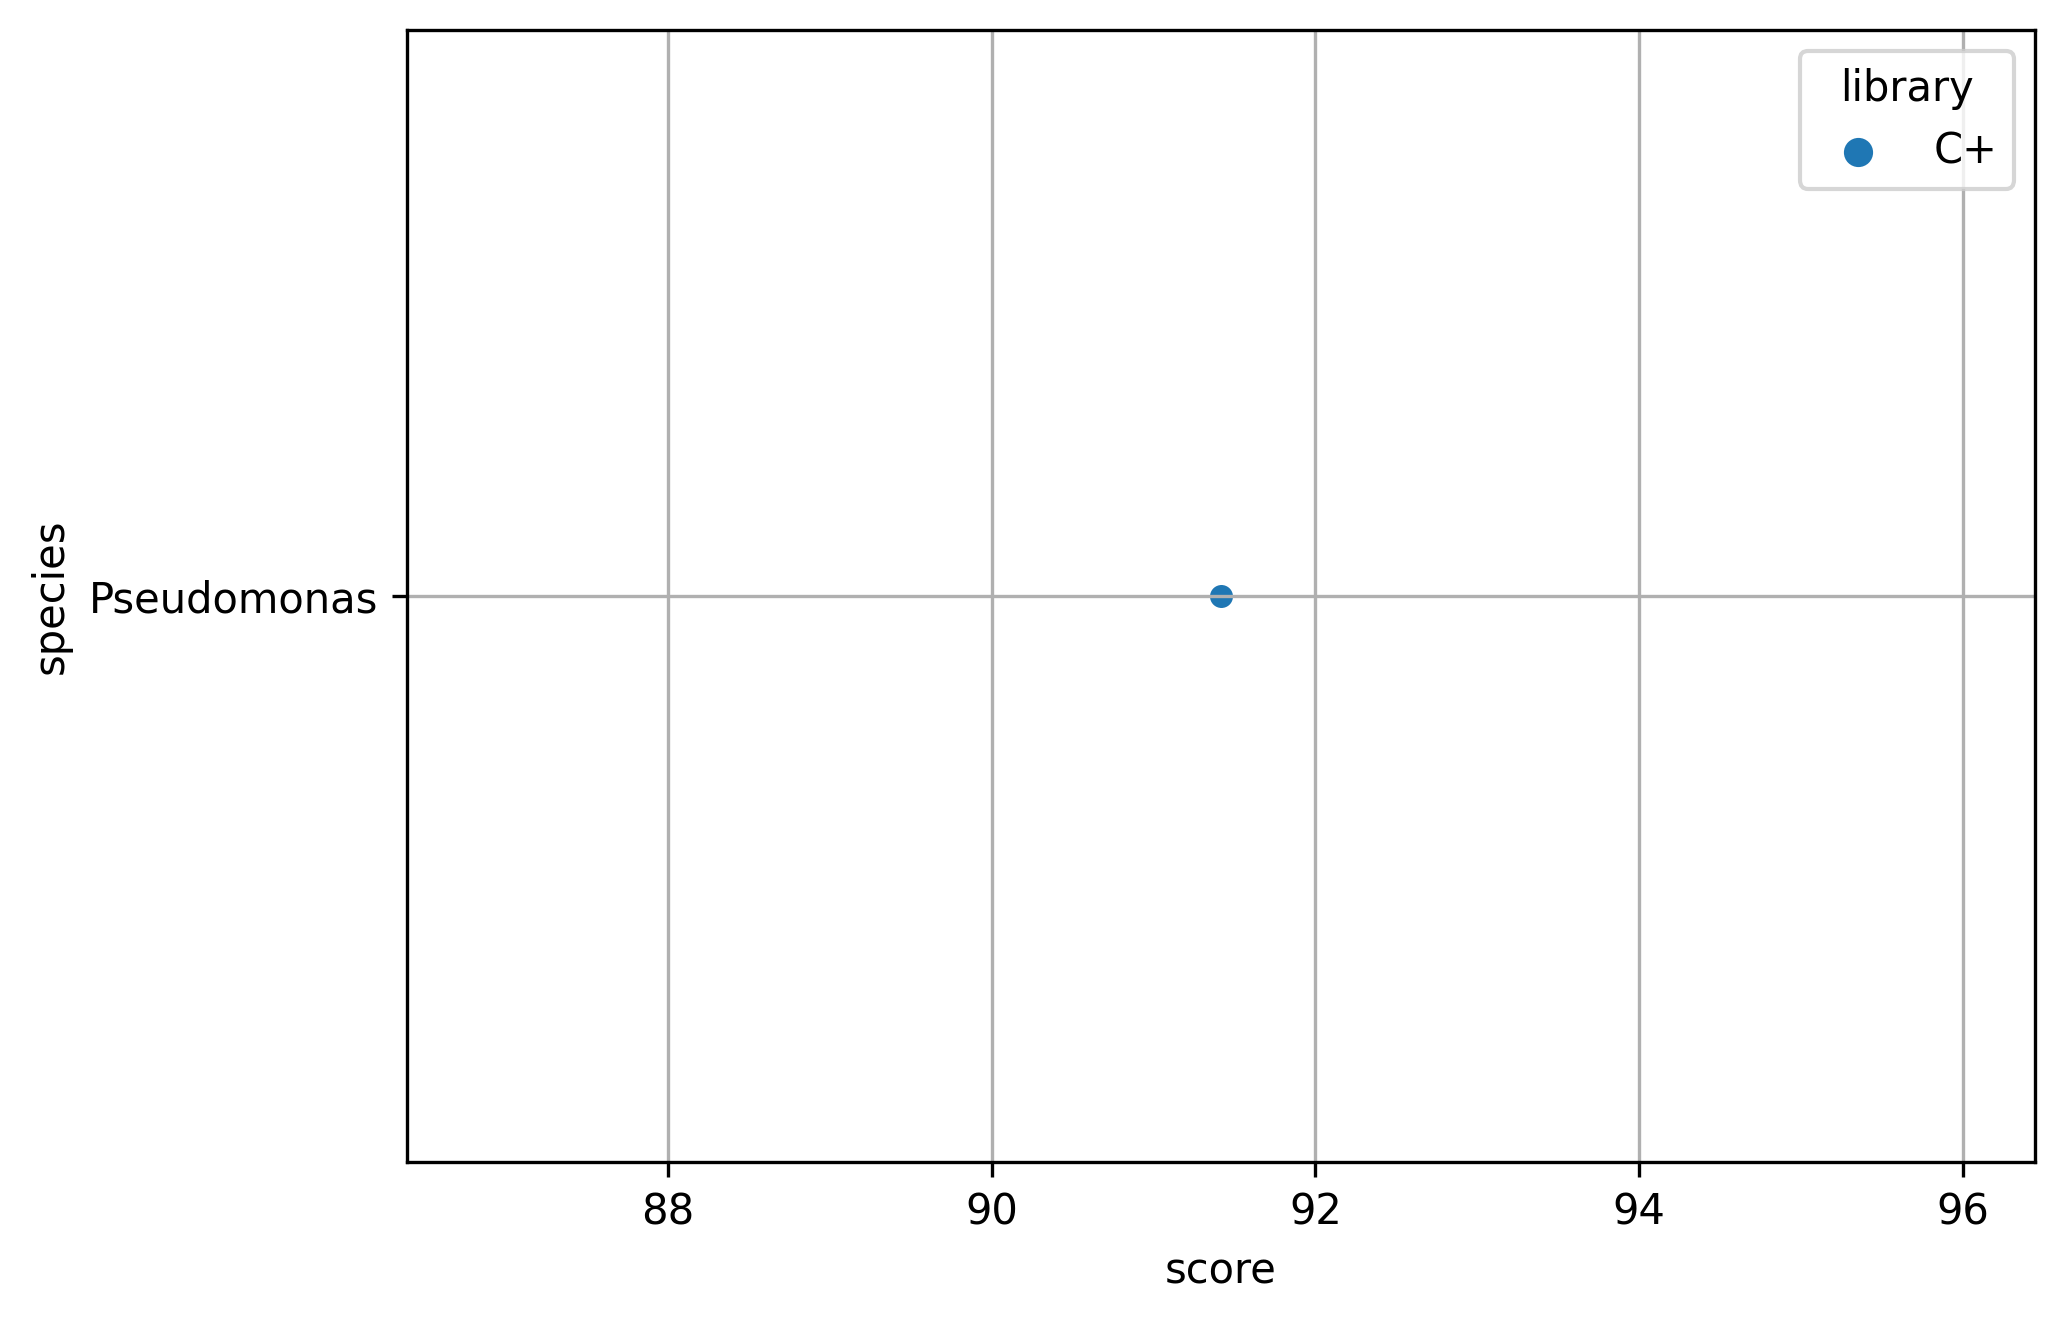

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
df = results.loc[(results['class']=='genus') & (results['score']>70)].sort_values(by=['score'], ascending=False)
plt.figure(figsize=(7, 5), dpi=300)
sns.scatterplot(data = df, y='entry', x='score', hue='library')
plt.grid()
plt.ylabel('species')

In [ ]:
C_plus = process_data('C+_reads.csv', 'C+_50conf_out.kraken2', 'C+_50_lineage.txt')

Text(0, 0.5, 'Species')

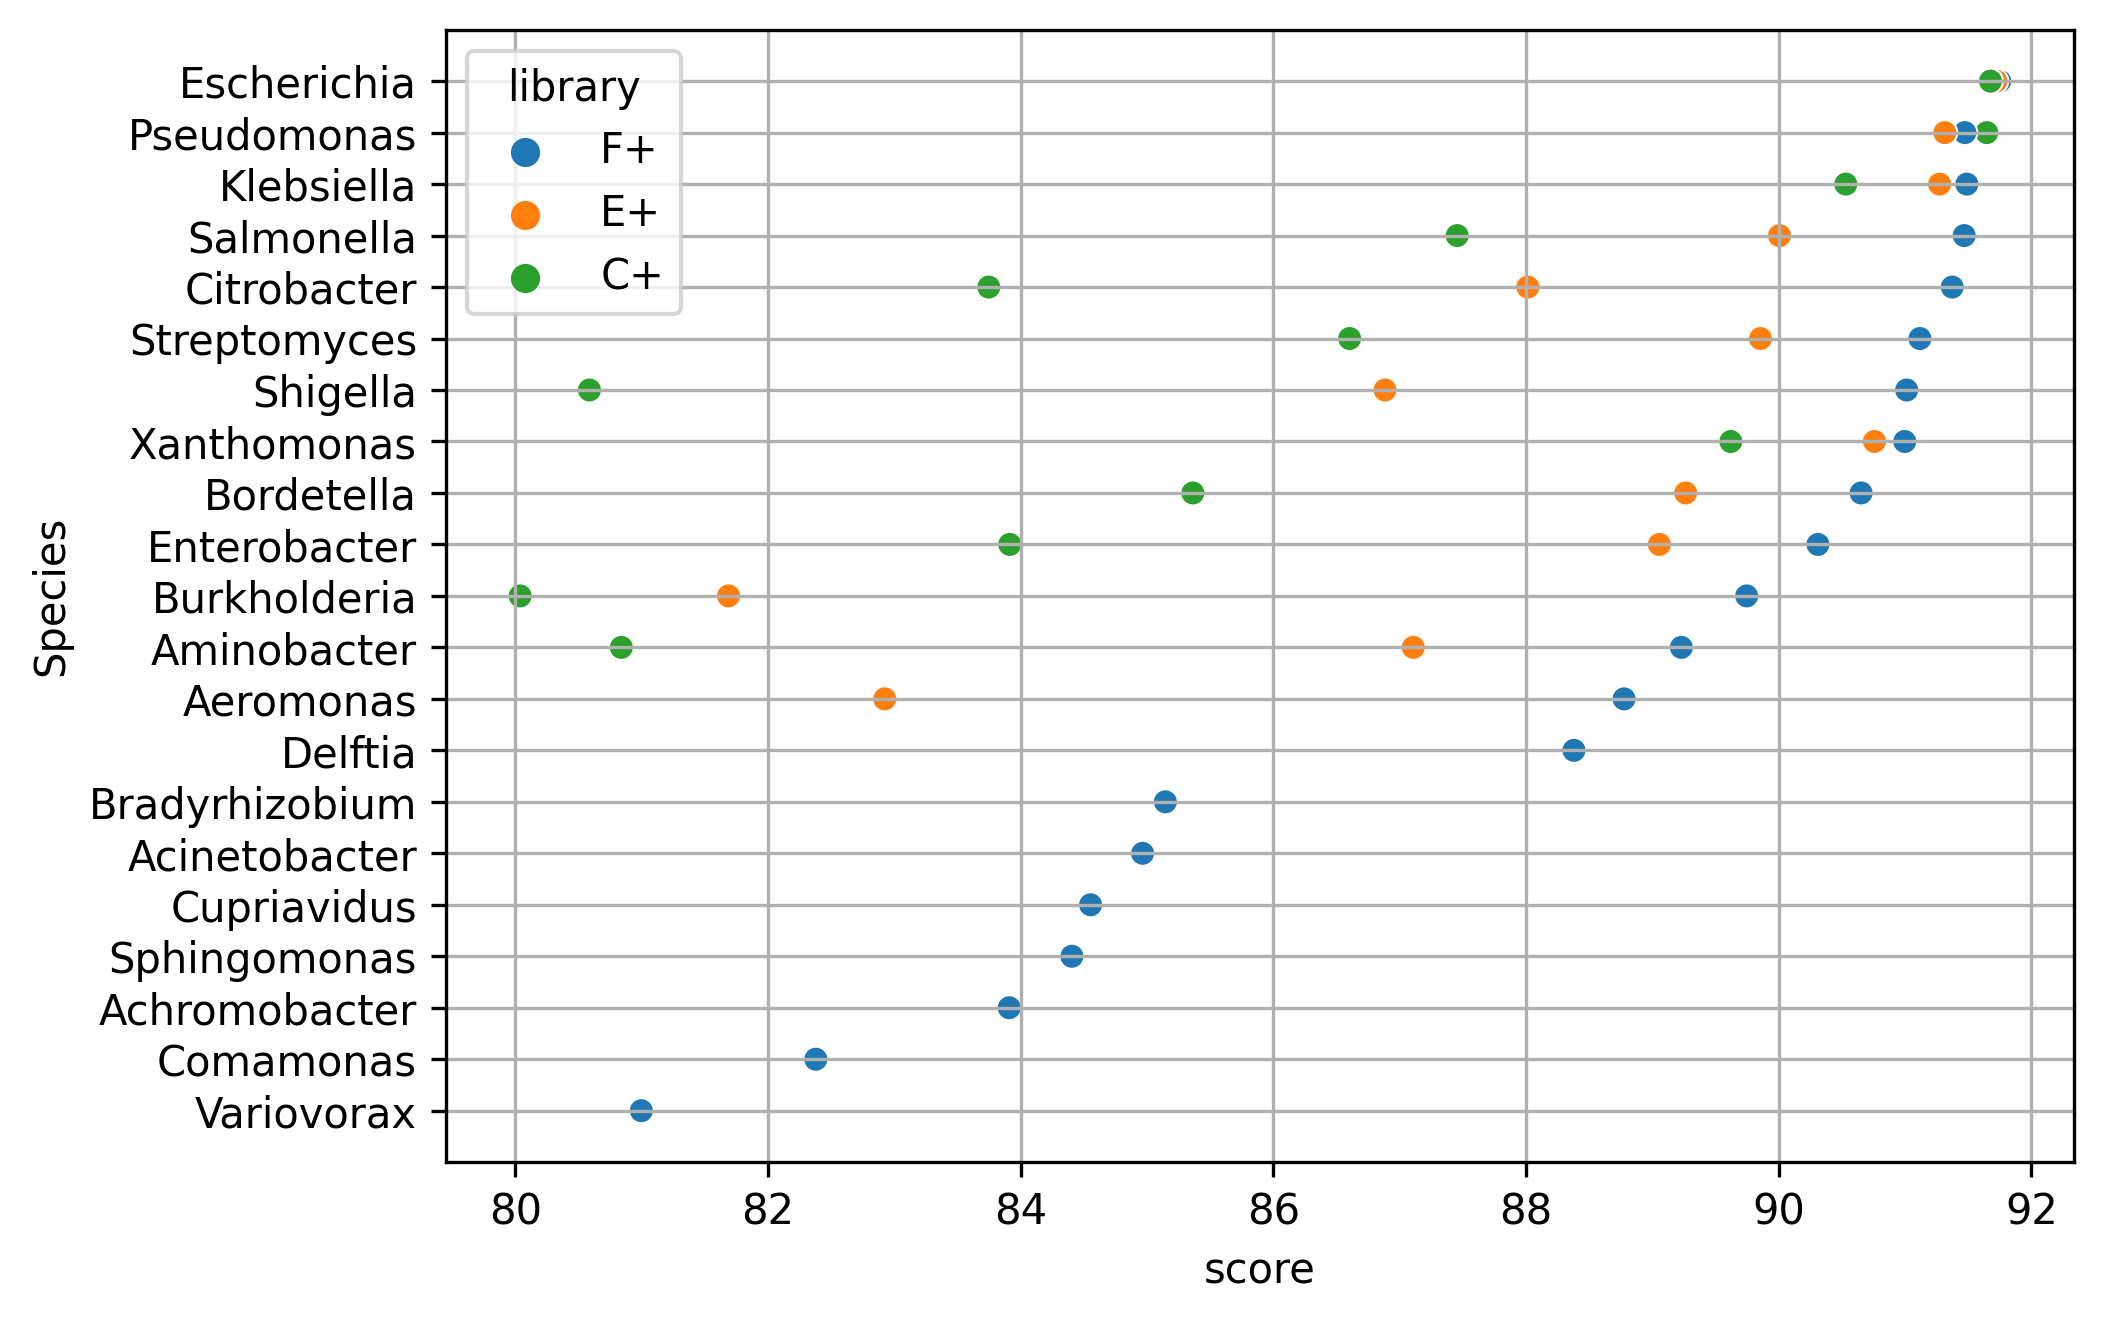

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
df = results.loc[(results['class']=='genus') & (results['score']>80)].sort_values(by=['score'], ascending=False)
plt.figure(figsize=(7, 5), dpi=300)
sns.scatterplot(data = df, y='entry', x='score', hue='library')
plt.grid()
plt.ylabel('Species')

In [133]:
test.loc[(test['class']=='species') & (test['score']>80)].sort_values(by=['score'], ascending=False)

,library,class,entry,percent_cov,percent_unique,score,reads
4129,C+,species,Escherichia coli,94.520448,88.851844,91.686146,15477
6071,C+,species,Pseudomonas putida,92.512986,85.928616,89.220801,2538
3374,C+,species,Klebsiella pneumoniae,92.384227,85.961361,89.172794,4861
4891,C+,species,Salmonella enterica,90.789377,83.966898,87.378138,3226
4505,C+,species,Xanthomonas translucens,88.073744,82.023041,85.048392,3415
5210,C+,species,Pseudomonas aeruginosa,88.836052,81.007948,84.922000,3460
5524,C+,species,Bordetella pertussis,82.765382,79.814247,81.289814,2335
2610,C+,species,Aminobacter sp. SR38,83.593533,76.849344,80.221438,3118


In [106]:
levels = ['kingdom','phylum','class','order','family','genus','species']

In [120]:
results['score'] = results.apply(lambda row: (row['percent_cov']+row['percent_unique'])/2, axis=1)
results.loc[(results['class']=='species') & (results['score']>50)].sort_values(by=['score'], ascending=False)

,class,entry,percent_cov,percent_unique,score
4129,species,Escherichia coli,94.520448,88.851844,91.686146
6071,species,Pseudomonas putida,92.512986,85.928616,89.220801
3374,species,Klebsiella pneumoniae,92.384227,85.961361,89.172794
4891,species,Salmonella enterica,90.789377,83.966898,87.378138
4505,species,Xanthomonas translucens,88.073744,82.023041,85.048392
5210,species,Pseudomonas aeruginosa,88.836052,81.007948,84.922000
5524,species,Bordetella pertussis,82.765382,79.814247,81.289814
2610,species,Aminobacter sp. SR38,83.593533,76.849344,80.221438
2114,species,Homo sapiens,74.845270,67.466436,71.155853
2616,species,Escherichia albertii,69.936352,64.831959,67.384156


In [ ]:
import os
import pandas as pd
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/')

reads = pd.concat(pd.read_csv('C+_reads.csv', chunksize=1000000, sep=','))
kraken = pd.concat(pd.read_csv('C+_out.kraken2', chunksize=1000000, sep='\t', header=None))
taxon = pd.concat(pd.read_csv('C+_lineage.txt', chunksize=1000000, sep='\t'))
taxon['classified'], taxon['seqid']  = kraken[0], kraken[1]
pothosts = reads.loc[(reads['link']=='unalignedpB10') | (reads['link']=='pB10unaligned')]
pothosts.drop(columns=['Unnamed: 0', 'R1align', 'R1', 'R2align', 'R2'], inplace=True)
complete_df = pothosts.merge(taxon, how='left',on='seqid')
no_unclassified = complete_df[complete_df['classified']=='C']
no_unclassified.drop(columns=['classified','taxid'], inplace=True)

In [163]:
no_unclassified

,seqid,link,R1length,R1loc,R2length,R2loc,kingdom,phylum,class,order,family,genus,species
0,A01335:60:HJVH2DRXY:1:2101:1072:4946,pB10unaligned,159,63095.0,159,2354107.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,NaN,NaN
1,A01335:60:HJVH2DRXY:1:2101:1072:5384,unalignedpB10,159,8230.0,159,8349.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
2,A01335:60:HJVH2DRXY:1:2101:1072:12054,pB10unaligned,159,61297.0,159,3789394.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,NaN,NaN
3,A01335:60:HJVH2DRXY:1:2101:1072:12493,unalignedpB10,159,42492.0,159,42460.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
4,A01335:60:HJVH2DRXY:1:2101:1072:16564,pB10unaligned,159,63687.0,159,2580.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13372840,A01335:60:HJVH2DRXY:1:2278:32895:33004,unalignedpB10,159,56613.0,159,56492.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,NaN
13372841,A01335:60:HJVH2DRXY:1:2278:32895:33285,unalignedpB10,159,47670.0,159,47694.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
13372842,A01335:60:HJVH2DRXY:1:2278:32895:34632,pB10unaligned,159,49292.0,159,2840279.0,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,NaN,NaN
13372843,A01335:60:HJVH2DRXY:1:2278:32895:34788,unalignedpB10,159,62478.0,159,58850.0,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
junction_seqs = []

In [74]:
blast_search = pd.read_csv('../../07_blast/blast_filt', sep='\t', header=None)
blast_search.columns = ['qseqid', 'qlen', 'sseqid', 'slen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'score', 'length', 'pident', 'nident']
all_seq = len(set(blast_search['qseqid']))
blast_search_filtered = blast_search.loc[blast_search['nident']>60]
filtered = len(set(blast_search_filtered['qseqid']))
print('all_seq: ', all_seq)
print('retained_seq: ', all_seq-filtered)

all_seq:  12565504
retained_seq:  888445


In [62]:
len(set(blast_search_filtered['qseqid']))

0

In [52]:
excluded
for query in set(blast_search['qseqid']):
    print(query)
    temp_df = blast_search[blast_search['qseqid']==query]
    temp_df = temp_df[temp_df['score']>50]
    print(temp_df)
    print('\n')

A01335:60:HJVH2DRXY:1:2101:1081:8970
                                  qseqid  qlen                    sseqid  \
78  A01335:60:HJVH2DRXY:1:2101:1081:8970   159  pB10::rfp-putative_37800   
79  A01335:60:HJVH2DRXY:1:2101:1081:8970   159  pB10::rfp-putative_37821   
80  A01335:60:HJVH2DRXY:1:2101:1081:8970   159  pB10::rfp-putative_43869   

    slen  qstart  qend  sstart  send        evalue  bitscore  score  length  \
78    70       8    77       1    70  1.360000e-32     130.0     70      70   
79    70      29    92       1    64  2.950000e-29     119.0     64      64   
80    70      97   159       1    63  1.060000e-28     117.0     63      63   

    pident  nident  
78   100.0      70  
79   100.0      64  
80   100.0      63  


A01335:60:HJVH2DRXY:1:2101:1072:16564
                                  qseqid  qlen                    sseqid  \
7  A01335:60:HJVH2DRXY:1:2101:1072:16564   159   pB10::rfp-putative_2583   
8  A01335:60:HJVH2DRXY:1:2101:1072:16564   159  pB10::rfp-putativ